# Lyrics analysis

In [1]:
# Import libraries
import pandas as pd
import numpy as np
from ast import literal_eval
from itertools import chain
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS
import nltk
from nltk import FreqDist
from nltk.corpus import stopwords
stop_words=set(nltk.corpus.stopwords.words('english'))
import sklearn
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

# ignore warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Load data with keeping structures inside data frame
songs = pd.read_csv('lyrics_processed_data.csv', converters = {'Tokenized Lyrics': literal_eval, 'Lemmatized Words': literal_eval}) 
display(songs)

,Position,Artist,Song Title,Year,JSON file,Split Names,Song Language,Lyrics,Tokenized Lyrics,Lemmatized Words,Corpus
0,1,Gordon Jenkins and The Weavers,Goodnight Irene,1950,0.json,Gordon Jenkins,en,irene goodnight irene goodnight goodnight iren...,"[irene, goodnight, irene, goodnight, goodnight...","[irene, goodnight, irene, goodnight, goodnight...",irene goodnight irene goodnight goodnight iren...
1,2,Nat King Cole,Mona Lisa,1950,1.json,Nat King Cole,en,"mona lisa, mona lisa, men have named you you'r...","[mona, lisa, mona, lisa, men, have, named, you...","[mona, lisa, mona, lisa, men, have, name, you,...",mona lisa mona lisa men name like lady mystic ...
2,4,Gary and Bing Crosby,Sam's Song,1950,3.json,Gary,en,"ah, here's a happy tune, you'll love to croon ...","[ah, here, s, a, happy, tune, you, ll, love, t...","[ah, here, s, a, happy, tune, you, ll, love, t...",ah happy tune love croon call sam song catchy ...
3,5,Gary and Bing Crosby,Simple Melody,1950,4.json,Gary,en,won't you play some simple melody like my moth...,"[won, t, you, play, some, simple, melody, like...","[win, t, you, play, some, simple, melody, like...",win play simple melody like mother sing one go...
4,6,Teresa Brewer,"Music, Music, Music",1950,5.json,Teresa Brewer,en,put another nickel in in the nickelodeon all i...,"[put, another, nickel, in, in, the, nickelodeo...","[put, another, nickel, in, in, the, nickelodeo...",put another nickel nickelodeon want music musi...
...,...,...,...,...,...,...,...,...,...,...,...
6404,95,Cole Swindell,Single Saturday Night,2021,6774.json,Cole Swindell,en,i was out taking shots throwing down at the sp...,"[i, was, out, taking, shots, throwing, down, a...","[i, be, out, take, shots, throw, down, at, the...",take shots throw spot three sheet guy every si...
6405,96,Lainey Wilson,Things A Man Oughta Know,2021,6775.json,Lainey Wilson,en,i can hook a trailer on a two-inch hitch i can...,"[i, can, hook, a, trailer, on, a, two, inch, h...","[i, can, hook, a, trailer, on, a, two, inch, h...",hook trailer two inch hitch shoot shotgun catc...
6406,97,BRS Kash,Throat Baby (Go Baby),2021,6776.json,BRS Kash,en,"(what's happenin', chi chi?) sexy lil' bitch...","[what, s, happenin, chi, chi, sexy, lil, bitch...","[what, s, happenin, chi, chi, sexy, lil, bitch...",happenin chi chi sexy lil bitch sexy lil ho lo...
6407,98,Rod Wave,Tombstone,2021,6777.json,Rod Wave,en,"damn, this motherfucker too crazy, saucii let ...","[damn, this, motherfucker, too, crazy, saucii,...","[damn, this, motherfucker, too, crazy, saucii,...",damn motherfucker crazy saucii let shit ride e...


Text(0.5, 1.0, "Count received songs' lyrics per year")

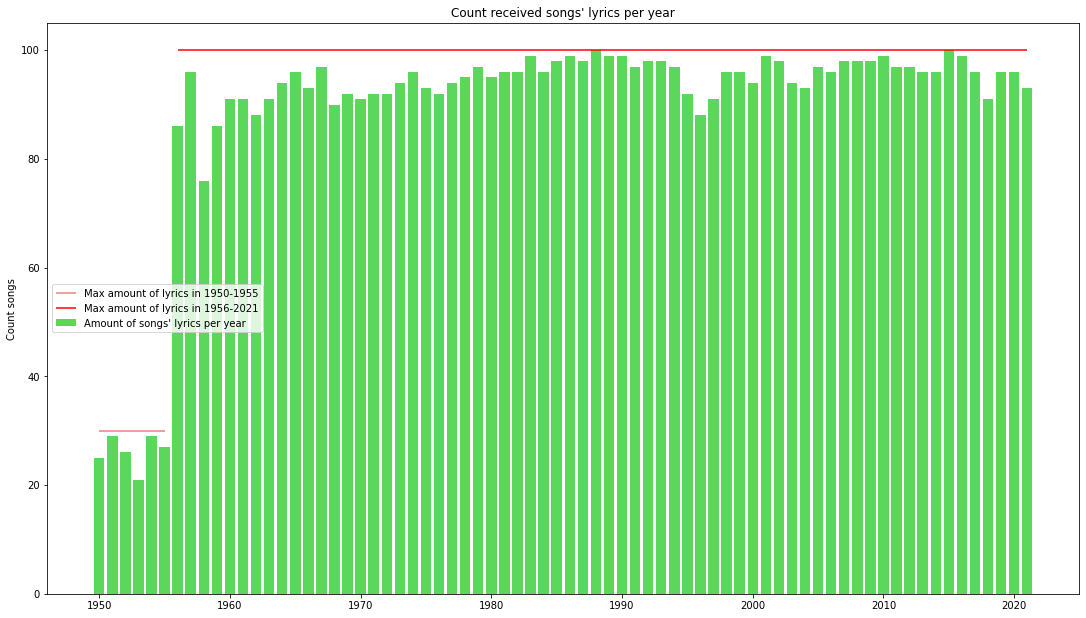

In [3]:
# Count received songs' lyrics per year
grouped_by_year = songs.groupby('Year').size()
plt.figure(figsize = (18.5, 10.5))
plt.bar(grouped_by_year.index, grouped_by_year, color = 'limegreen', alpha = 0.8)
plt.hlines(y = 30, xmin = 1950, xmax = 1955, colors = 'lightcoral')
plt.hlines(y = 100, xmin = 1956, xmax = 2021, colors='r')
plt.ylabel('Count songs')
plt.legend(['Max amount of lyrics in 1950-1955', 'Max amount of lyrics in 1956-2021', 'Amount of songs\' lyrics per year'], loc = 6)
plt.title('Count received songs\' lyrics per year')

Text(0.5, 1.0, "Average amount of words and unique words in songs' lyrics per year")

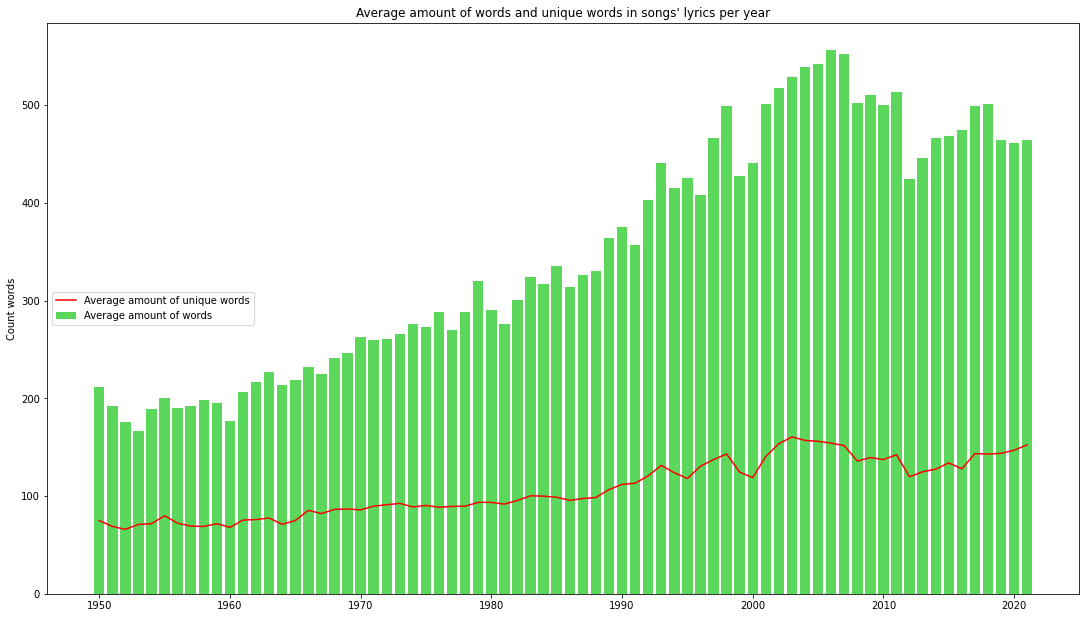

In [4]:
# Average number of words and unique in lyrics
unique = [len(set(i)) for i in songs['Tokenized Lyrics']]
songs['Tokenized Lyrics length'] = songs['Tokenized Lyrics'].str.len()
songs['Tokenized Unique Lyrics length'] = unique
grouped_mean = songs.groupby('Year')['Tokenized Lyrics length'].mean()
grouped_unique_mean = songs.groupby('Year')['Tokenized Unique Lyrics length'].mean()

plt.figure(figsize = (18.5, 10.5))
plt.bar(grouped_mean.index, grouped_mean, color = 'limegreen', alpha = 0.8)
plt.plot(grouped_unique_mean, color = 'r')
plt.ylabel('Count words')
plt.legend(['Average amount of unique words', 'Average amount of words'], loc = 6)
plt.title('Average amount of words and unique words in songs\' lyrics per year')

### Word cloud

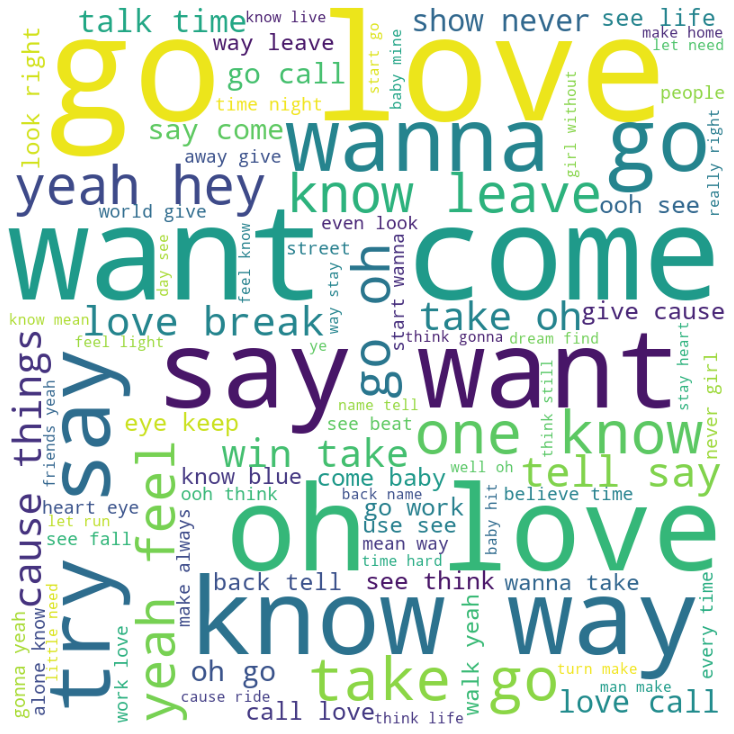

In [5]:
set_lyrics = [set(i) for i in songs['Corpus'].str.split()]
set_lyrics = list(chain(*set_lyrics))
join_lyrics = (" ").join(set_lyrics)

wordcloud = WordCloud(width = 800, height = 800, background_color = 'white', stopwords = STOPWORDS, min_font_size = 15).generate(join_lyrics)
plt.figure(figsize = (18.5, 10), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
plt.show()

### Most popular words

In [6]:
# Three most popular words each year
songs_by_year = pd.DataFrame({'Year':list(range(1950, 2022))})
lyrics_per_year = []

# Function for converting list of lists to list of sets
def lists_to_sets(l):
    return [{i for i in row} for row in l]

# Combination of lyrics per year
years = songs['Year'].unique().tolist()
for i in years:
    song_lyrics = songs['Corpus'].str.split()[songs['Year'] == i].to_list()
    set_song_lyrics = lists_to_sets(song_lyrics)
    flat_song_lyrics = [item for i in set_song_lyrics for item in i]
    lyrics_per_year.append(flat_song_lyrics)
    
# Set for every song in particular year
songs_by_year['Combined Lyrics'] = lyrics_per_year


# Function for getting first values from tuple of most popular words
def first_from_list_of_tuples(lst):
    return [i[0] for i in lst]

lst_of_top3_words = [] 

# Create list of top 3 popular words
for i in songs_by_year['Combined Lyrics']:
    frq = FreqDist(i)
    top3_words = first_from_list_of_tuples(frq.most_common(3))
    lst_of_top3_words.append(top3_words)

# Set for every song in particular year
songs_by_year['Most Popular Words'] = lst_of_top3_words

display(songs_by_year)

,Year,Combined Lyrics,Most Popular Words
0,1950,"[sometimes, notion, another, dream, night, set...","[love, see, like]"
1,1951,"[may, us, recall, tell, try, say, begin, reall...","[love, heart, know]"
2,1952,"[sigh, dream, please, let, yearn, turn, even, ...","[love, know, kiss]"
3,1953,"[melt, sad, please, may, realise, must, close,...","[love, come, go]"
4,1954,"[money, across, little, care, cry, gray, diamo...","[love, heart, know]"
...,...,...,...
67,2017,"[place, hours, find, let, follow, get, want, c...","[get, like, know]"
68,2018,"[good, sometimes, eighty, get, close, differen...","[like, yeah, get]"
69,2019,"[attach, match, valley, road, gucci, hor, get,...","[get, know, yeah]"
70,2020,"[empty, time, maybe, night, trust, drown, run,...","[get, like, know]"


In [7]:
# 3 the most popular words of 1950 - 2021
most_popular_words_list = songs_by_year['Most Popular Words'].tolist()
most_popular_words = first_from_list_of_tuples(Counter(chain.from_iterable(most_popular_words_list)).most_common(3))
most_popular_words

['know', 'get', 'love']

Text(0.5, 1.0, 'Occurence of the most popular words')

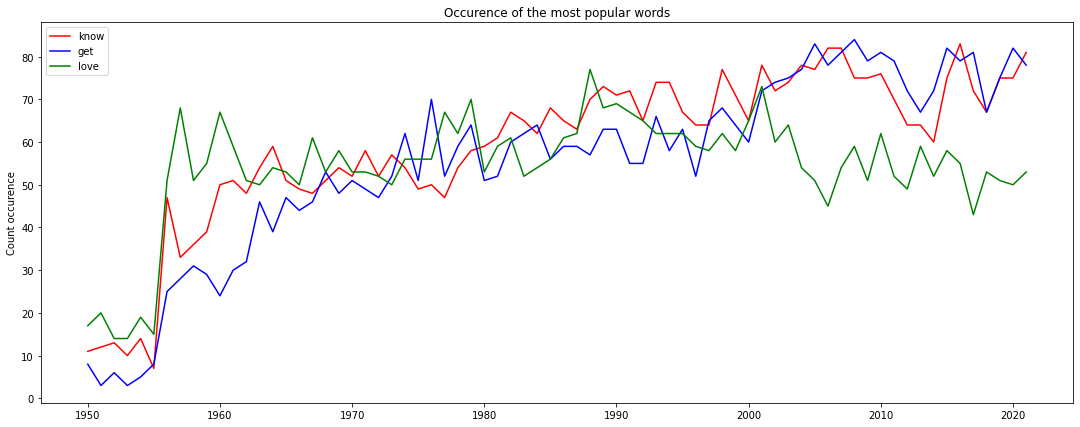

In [8]:
# Popular words occurence plot
def count_most_popular_word(list_of_words, word):
    return list_of_words.count(word)

first_most_popular_word_occurence = [count_most_popular_word(i, most_popular_words[0]) for i in songs_by_year['Combined Lyrics']]
second_most_popular_word_occurence = [count_most_popular_word(i, most_popular_words[1]) for i in songs_by_year['Combined Lyrics']]
third_most_popular_word_occurence = [count_most_popular_word(i, most_popular_words[2]) for i in songs_by_year['Combined Lyrics']]

plt.figure(figsize = (18.5, 7))
plt.plot(songs_by_year['Year'], first_most_popular_word_occurence, color = 'red', label = most_popular_words[0])
plt.plot(songs_by_year['Year'], second_most_popular_word_occurence, color = 'blue', label = most_popular_words[1])
plt.plot(songs_by_year['Year'], third_most_popular_word_occurence, color = 'green', label = most_popular_words[2])
plt.ylabel('Count occurence')
plt.legend(most_popular_words)
plt.title('Occurence of the most popular words')

### Bad words classifier

In [9]:
# List of bad words
bad_words_df = pd.read_csv('https://www.cs.cmu.edu/~biglou/resources/bad-words.txt', sep = "\n", header = None, names = ["Word"])
bad_words = bad_words_df["Word"].tolist()

In [10]:
# Measure level of vulgarity for each song in years 1950 - 2021 (in %)
# Calculate % of bad words
def level_of_vulgarity(lemm_list):
    counter = 0
    for i in lemm_list:
        if i in bad_words:
            counter += 1
    level = counter / len(lemm_list) * 100
    return level

list_of_levels = []
for i in songs['Corpus'].str.split():
    list_of_levels.append(level_of_vulgarity(i))
    
songs['Vulgarity Level'] = list_of_levels
songs['Vulgarity Level'] = songs['Vulgarity Level'].round(2)

display(songs[['Position', 'Artist', 'Song Title', 'Year', 'Vulgarity Level']])

,Position,Artist,Song Title,Year,Vulgarity Level
0,1,Gordon Jenkins and The Weavers,Goodnight Irene,1950,0.00
1,2,Nat King Cole,Mona Lisa,1950,2.90
2,4,Gary and Bing Crosby,Sam's Song,1950,0.00
3,5,Gary and Bing Crosby,Simple Melody,1950,3.09
4,6,Teresa Brewer,"Music, Music, Music",1950,0.00
...,...,...,...,...,...
6404,95,Cole Swindell,Single Saturday Night,2021,2.62
6405,96,Lainey Wilson,Things A Man Oughta Know,2021,3.20
6406,97,BRS Kash,Throat Baby (Go Baby),2021,13.39
6407,98,Rod Wave,Tombstone,2021,7.66


Text(0.5, 1.0, 'Vulgarity level of lyrics')

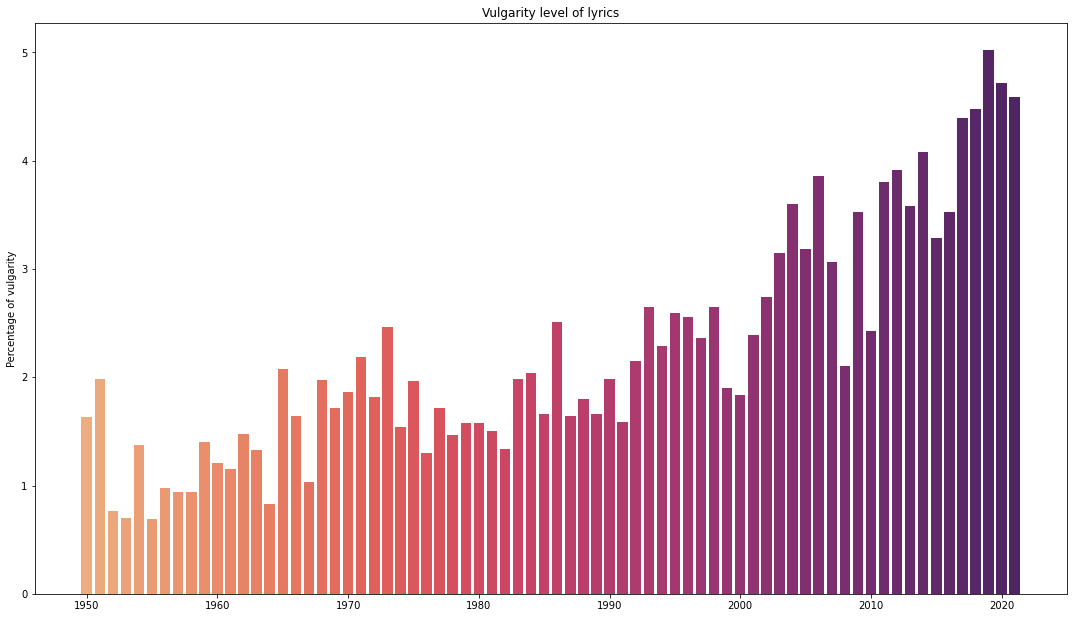

In [11]:
# Vulgarity level each year plot
grouped_vulgsrity = songs.groupby('Year')['Vulgarity Level'].aggregate('mean').tolist()
songs_by_year['Mean Vulgarity'] = grouped_vulgsrity
plt.figure(figsize = (18.5, 10.5))
plt.bar(songs_by_year['Year'], grouped_vulgsrity, color = sns.color_palette('flare', len(songs_by_year)))
plt.ylabel('Percentage of vulgarity')
plt.title('Vulgarity level of lyrics')

In [12]:
# 3 most popular words classified as bad words each year
lst_of_top3_bad_words = []

for i in songs_by_year['Combined Lyrics']:
    i = pd.Series(i)
    bad_words_series = pd.Series(bad_words)
    bad_lyrics = i[i.isin(bad_words_series)]
    frq = FreqDist(bad_lyrics)
    top3_bad_words = first_from_list_of_tuples(frq.most_common(3))
    lst_of_top3_bad_words.append(top3_bad_words)
    
songs_by_year['Most Popular Bad Words'] = lst_of_top3_bad_words

display(songs_by_year)

,Year,Combined Lyrics,Most Popular Words,Mean Vulgarity,Most Popular Bad Words
0,1950,"[sometimes, notion, another, dream, night, set...","[love, see, like]",1.633200,"[fire, die, demon]"
1,1951,"[may, us, recall, tell, try, say, begin, reall...","[love, heart, know]",1.980345,"[die, burn, desire]"
2,1952,"[sigh, dream, please, let, yearn, turn, even, ...","[love, know, kiss]",0.761538,"[fire, desire, crash]"
3,1953,"[melt, sad, please, may, realise, must, close,...","[love, come, go]",0.698571,"[die, burn, death]"
4,1954,"[money, across, little, care, cry, gray, diamo...","[love, heart, know]",1.375517,"[boom, fear, die]"
...,...,...,...,...,...
67,2017,"[place, hours, find, let, follow, get, want, c...","[get, like, know]",4.397917,"[bitch, fuck, shit]"
68,2018,"[good, sometimes, eighty, get, close, differen...","[like, yeah, get]",4.473626,"[shit, bitch, fuck]"
69,2019,"[attach, match, valley, road, gucci, hor, get,...","[get, know, yeah]",5.020625,"[shit, fuck, bitch]"
70,2020,"[empty, time, maybe, night, trust, drown, run,...","[get, like, know]",4.717083,"[bitch, fuck, shit]"


In [13]:
# 3 the most popular bad words of 1950 - 2021
most_popular_bad_words_list = songs_by_year['Most Popular Bad Words'].tolist()
most_popular_bad_words = first_from_list_of_tuples(Counter(chain.from_iterable(most_popular_bad_words_list)).most_common(3))
most_popular_bad_words

['die', 'shit', 'fire']

Text(0.5, 1.0, 'Occurence of the most popular bad words')

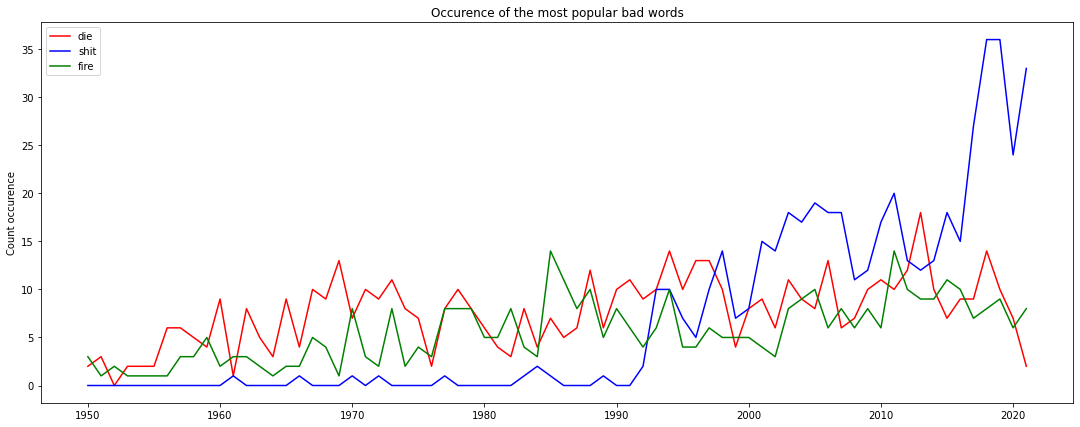

In [14]:
# Popular bad words occurence plot
first_most_popular_bad_word_occurence = [count_most_popular_word(i, most_popular_bad_words[0]) for i in songs_by_year['Combined Lyrics']]
second_most_popular_bad_word_occurence = [count_most_popular_word(i, most_popular_bad_words[1]) for i in songs_by_year['Combined Lyrics']]
third_most_popular_bad_word_occurence = [count_most_popular_word(i, most_popular_bad_words[2]) for i in songs_by_year['Combined Lyrics']]

plt.figure(figsize = (18.5, 7))
plt.plot(songs_by_year['Year'], first_most_popular_bad_word_occurence, color = 'red', label = most_popular_words[0])
plt.plot(songs_by_year['Year'], second_most_popular_bad_word_occurence, color = 'blue', label = most_popular_words[1])
plt.plot(songs_by_year['Year'], third_most_popular_bad_word_occurence, color = 'green', label = most_popular_words[2])
plt.ylabel('Count occurence')
plt.legend(most_popular_bad_words)
plt.title('Occurence of the most popular bad words')

### Sentiment analysis

In [15]:
# pd.set_option("display.max_rows", None, "display.max_columns", None)
sentiment = SentimentIntensityAnalyzer()
negative = []
neutral = []
positive = []
compound = []
rate = []
for i in songs['Corpus']:
    sent = sentiment.polarity_scores(i)
    negative.append(sent['neg'])
    neutral.append(sent['neu'])
    positive.append(sent['pos'])
    compound.append(sent['compound'])
    if sent['compound'] > 0:
        rate.append('Positive')
    elif sent['compound'] < 0:
        rate.append('Negative')
    else:
        rate.append('Neutral')
songs['Negative'] = negative
songs['Neutral'] = neutral
songs['Positive'] = positive
songs['Compound'] = compound
songs['Rate'] = rate

display(songs[['Position', 'Artist', 'Song Title', 'Year', 'Negative', 'Neutral', 'Positive', 'Compound', 'Rate']])

,Position,Artist,Song Title,Year,Negative,Neutral,Positive,Compound,Rate
0,1,Gordon Jenkins and The Weavers,Goodnight Irene,1950,0.100,0.755,0.145,0.5719,Positive
1,2,Nat King Cole,Mona Lisa,1950,0.190,0.414,0.395,0.9712,Positive
2,4,Gary and Bing Crosby,Sam's Song,1950,0.077,0.653,0.270,0.9888,Positive
3,5,Gary and Bing Crosby,Simple Melody,1950,0.085,0.419,0.495,0.9961,Positive
4,6,Teresa Brewer,"Music, Music, Music",1950,0.000,0.743,0.257,0.9840,Positive
...,...,...,...,...,...,...,...,...,...
6404,95,Cole Swindell,Single Saturday Night,2021,0.087,0.735,0.178,0.9716,Positive
6405,96,Lainey Wilson,Things A Man Oughta Know,2021,0.104,0.573,0.323,0.9905,Positive
6406,97,BRS Kash,Throat Baby (Go Baby),2021,0.135,0.564,0.300,0.9979,Positive
6407,98,Rod Wave,Tombstone,2021,0.224,0.437,0.339,0.9766,Positive


In [16]:
# Mean sentiment per year
neg = songs.groupby('Year')['Negative'].aggregate('mean').tolist()
neu = songs.groupby('Year')['Neutral'].aggregate('mean').tolist()
pos = songs.groupby('Year')['Positive'].aggregate('mean').tolist()
comp = songs.groupby('Year')['Compound'].aggregate('mean').tolist()
songs_by_year['Negative'] = neg
songs_by_year['Neutral'] = neu
songs_by_year['Positive'] = pos
songs_by_year['Compound'] = comp
display(songs_by_year)

,Year,Combined Lyrics,Most Popular Words,Mean Vulgarity,Most Popular Bad Words,Negative,Neutral,Positive,Compound
0,1950,"[sometimes, notion, another, dream, night, set...","[love, see, like]",1.633200,"[fire, die, demon]",0.068840,0.512800,0.418200,0.968292
1,1951,"[may, us, recall, tell, try, say, begin, reall...","[love, heart, know]",1.980345,"[die, burn, desire]",0.097586,0.538931,0.363552,0.783852
2,1952,"[sigh, dream, please, let, yearn, turn, even, ...","[love, know, kiss]",0.761538,"[fire, desire, crash]",0.100308,0.586308,0.313500,0.716292
3,1953,"[melt, sad, please, may, realise, must, close,...","[love, come, go]",0.698571,"[die, burn, death]",0.100667,0.497333,0.402000,0.842881
4,1954,"[money, across, little, care, cry, gray, diamo...","[love, heart, know]",1.375517,"[boom, fear, die]",0.072517,0.535517,0.391828,0.948190
...,...,...,...,...,...,...,...,...,...
67,2017,"[place, hours, find, let, follow, get, want, c...","[get, like, know]",4.397917,"[bitch, fuck, shit]",0.152344,0.590302,0.257396,0.407922
68,2018,"[good, sometimes, eighty, get, close, differen...","[like, yeah, get]",4.473626,"[shit, bitch, fuck]",0.151967,0.580593,0.267495,0.437093
69,2019,"[attach, match, valley, road, gucci, hor, get,...","[get, know, yeah]",5.020625,"[shit, fuck, bitch]",0.167365,0.585844,0.246792,0.313159
70,2020,"[empty, time, maybe, night, trust, drown, run,...","[get, like, know]",4.717083,"[bitch, fuck, shit]",0.161760,0.593448,0.244823,0.303282


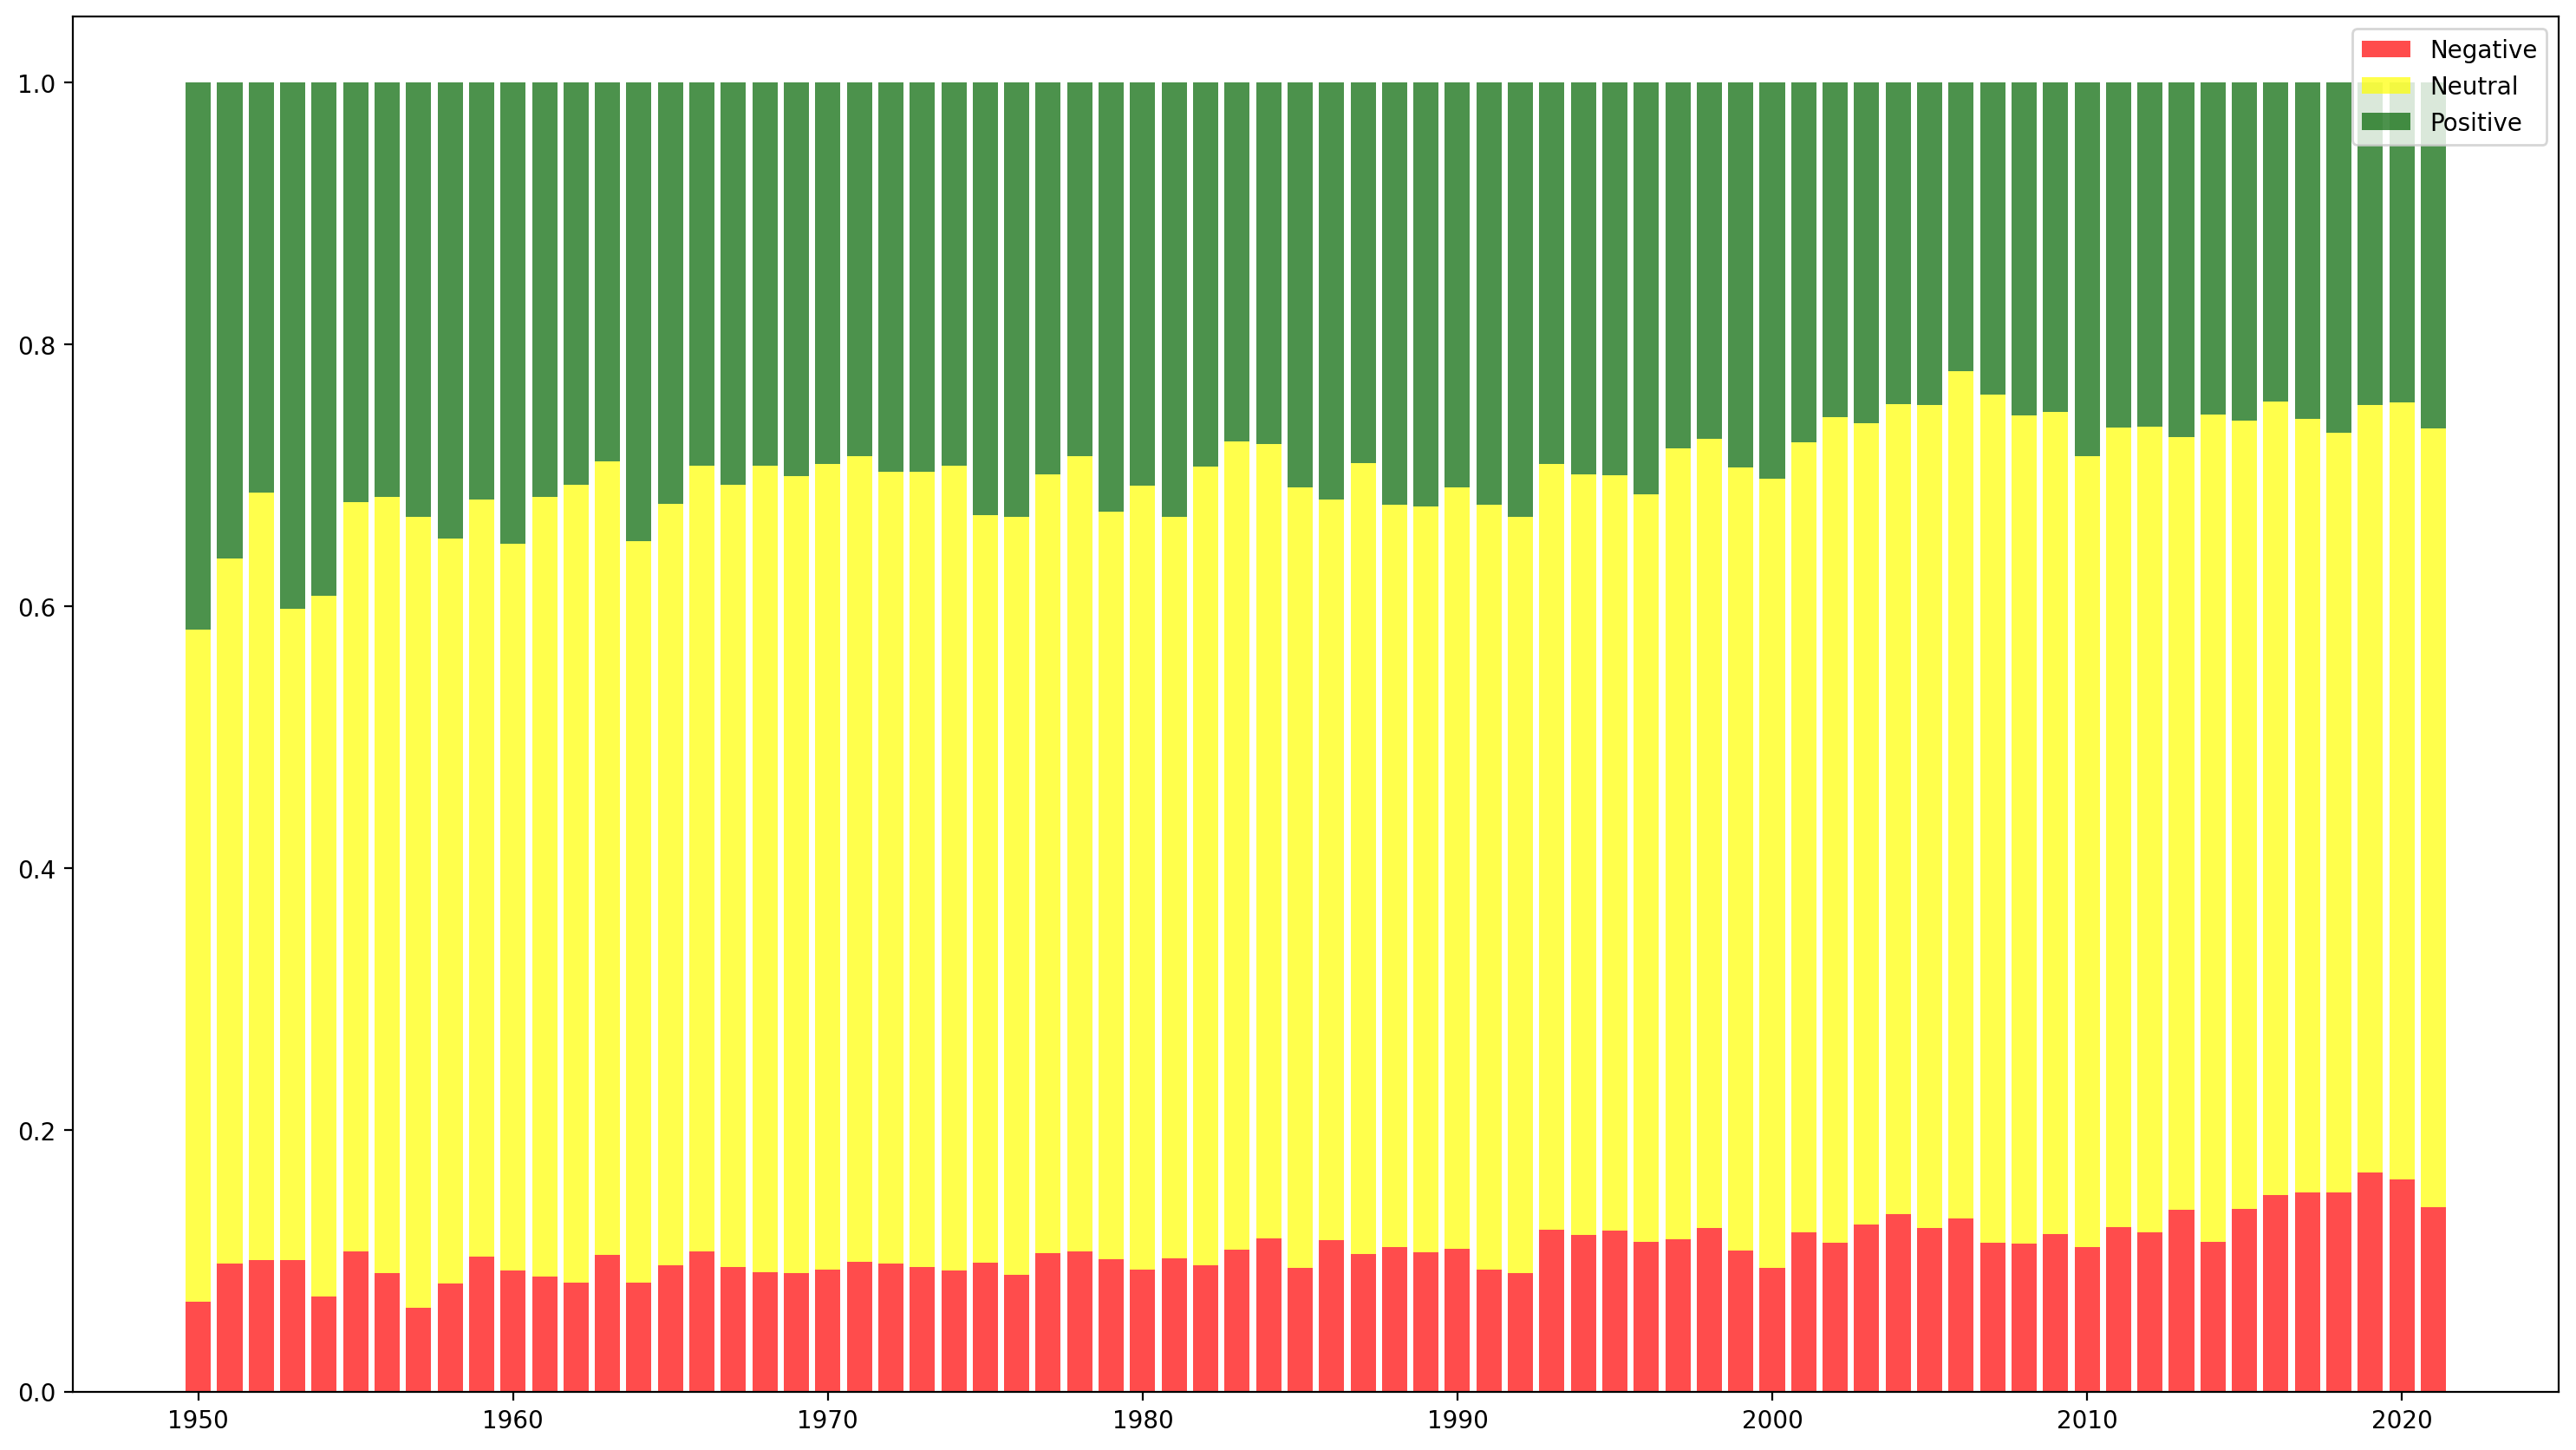

In [17]:
plt.figure(figsize=(18.5, 10.5), dpi=200)
plt.bar(songs_by_year['Year'], songs_by_year['Negative'], color = 'red', label = 'Negative', alpha = 0.7)
plt.bar(songs_by_year['Year'], songs_by_year['Neutral'], color = 'yellow', bottom = songs_by_year['Negative'].values, label = 'Neutral', alpha = 0.7)
plt.bar(songs_by_year['Year'], songs_by_year['Positive'], color = 'darkgreen', bottom = list(np.add(songs_by_year['Negative'].values, songs_by_year['Neutral'].values)), label = "Positive", alpha = 0.7)
plt.legend()
plt.show()

### The most positive and negative songs

In [18]:
# The most positive songs
display(songs[['Position', 'Artist', 'Song Title', 'Year', 'Negative', 'Neutral', 'Positive', 'Compound', 'Rate']].sort_values(['Positive', 'Neutral', 'Negative'], ascending = False).head(5))

,Position,Artist,Song Title,Year,Negative,Neutral,Positive,Compound,Rate
874,14,Beatles,Love Me Do,1964,0.000,0.128,0.872,0.9992,Positive
1994,15,Diana Ross,Love Hangover,1976,0.007,0.138,0.856,1.0000,Positive
465,59,Frankie Avalon,Just Ask Your Heart,1959,0.000,0.163,0.837,0.9992,Positive
637,52,Paris Sisters,I Love How You Love Me,1961,0.047,0.127,0.827,0.9994,Positive
524,24,Frankie Avalon,Why,1960,0.042,0.151,0.807,0.9991,Positive


In [19]:
# The most negative songs
display(songs[['Position', 'Artist', 'Song Title', 'Year', 'Negative', 'Neutral', 'Positive', 'Compound', 'Rate']].sort_values(['Negative', 'Neutral', 'Positive'], ascending = False).head(5))

,Position,Artist,Song Title,Year,Negative,Neutral,Positive,Compound,Rate
6008,75,Jon Bellion,All Time Low,2017,0.808,0.136,0.057,-0.9998,Negative
5502,57,Big Sean feat. Nicki Minaj,Dance (A$$),2012,0.716,0.216,0.068,-0.9999,Negative
4159,66,Ace Of Base,Cruel Summer,1998,0.706,0.246,0.048,-0.9993,Negative
2816,73,Bananarama,Cruel Summer,1984,0.705,0.239,0.056,-0.9991,Negative
2004,26,K.C. and The Sunshine Band,"(Shake, Shake, Shake) Shake Your Booty",1976,0.688,0.219,0.093,-0.9975,Negative


### Statistics for the most popular artists

In [20]:
# The most popular artists
most_popular_artists = songs['Artist'].value_counts().head(5).index.tolist()

most_popular_artists_songs = songs.query('Artist in @most_popular_artists')
display(most_popular_artists_songs)

,Position,Artist,Song Title,Year,JSON file,Split Names,Song Language,Lyrics,Tokenized Lyrics,Lemmatized Words,Corpus,Tokenized Lyrics length,Tokenized Unique Lyrics length,Vulgarity Level,Negative,Neutral,Positive,Compound,Rate
157,1,Elvis Presley,Heartbreak Hotel,1956,180.json,Elvis Presley,en,"well, since my baby left me well, i found a ne...","[well, since, my, baby, left, me, well, i, fou...","[well, since, my, baby, leave, me, well, i, fi...",well since baby leave well find new place dwel...,237,81,4.81,0.481,0.350,0.168,-0.9947,Negative
158,2,Elvis Presley,Don't Be Cruel,1956,181.json,Elvis Presley,en,you know i can be found sitting home all alone...,"[you, know, i, can, be, found, sitting, home, ...","[you, know, i, can, be, find, sit, home, all, ...",know find sit home alone come around least ple...,222,80,1.25,0.217,0.287,0.496,0.9922,Positive
164,8,Elvis Presley,Hound Dog,1956,187.json,Elvis Presley,en,you ain't nothin' but a hound dog cryin' all t...,"[you, ain, t, nothin, but, a, hound, dog, cryi...","[you, ain, t, nothin, but, a, hound, dog, cryi...",nothin hound dog cryin time nothin hound dog c...,254,34,0.00,0.119,0.656,0.225,0.8415,Positive
169,14,Elvis Presley,"I Want You, I Need You, I Love You",1956,193.json,Elvis Presley,en,"hold me close, hold me tight make me thrill wi...","[hold, me, close, hold, me, tight, make, me, t...","[hold, me, close, hold, me, tight, make, me, t...",hold close hold tight make thrill delight let ...,177,65,2.70,0.118,0.334,0.548,0.9945,Positive
170,15,Elvis Presley,Love Me Tender,1956,194.json,Elvis Presley,en,"love me tender, love me sweet never let me go ...","[love, me, tender, love, me, sweet, never, let...","[love, me, tender, love, me, sweet, never, let...",love tender love sweet never let go make life ...,128,51,0.00,0.026,0.227,0.747,0.9984,Positive
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4949,91,Madonna,Hung Up,2006,5270.json,Madonna,en,time goes by so slowly time goes by so slowly ...,"[time, goes, by, so, slowly, time, goes, by, s...","[time, go, by, so, slowly, time, go, by, so, s...",time go slowly time go slowly time go slowly t...,539,80,0.00,0.032,0.953,0.014,-0.4588,Negative
5077,22,Mariah Carey,Touch My Body,2008,5401.json,Mariah Carey,en,"mc! uh, uh, uh, in the place to be oh yeah, oh...","[mc, uh, uh, uh, in, the, place, to, be, oh, y...","[mc, uh, uh, uh, in, the, place, to, be, oh, y...",mc uh uh uh place oh yeah oh yeah oh yeah oh y...,638,147,0.31,0.006,0.689,0.305,0.9985,Positive
5194,41,Mariah Carey,Obsessed,2009,5520.json,Mariah Carey,en,"i was like, ""why are you so obsessed with me?""...","[i, was, like, why, are, you, so, obsessed, wi...","[i, be, like, why, be, you, so, obsess, with, ...",like obsess oh oh oh oh ay ay ay oh oh oh oh a...,748,153,2.74,0.192,0.691,0.118,-0.9392,Negative
6283,67,Mariah Carey,All I Want For Christmas Is You,2020,6646.json,Mariah Carey,en,i don't want a lot for christmas there is just...,"[i, don, t, want, a, lot, for, christmas, ther...","[i, don, t, want, a, lot, for, christmas, ther...",want lot christmas one thing need care present...,405,114,0.00,0.000,0.601,0.399,0.9977,Positive


In [21]:
grouped_by_artist = most_popular_artists_songs.groupby('Artist')[['Compound', 'Vulgarity Level']].aggregate('mean')
display(grouped_by_artist)

,Compound,Vulgarity Level
Artist,,
Beatles,0.791242,1.376538
Elton John,0.484058,2.409167
Elvis Presley,0.621144,2.352500
Madonna,0.861129,0.986000
Mariah Carey,0.663430,1.478519


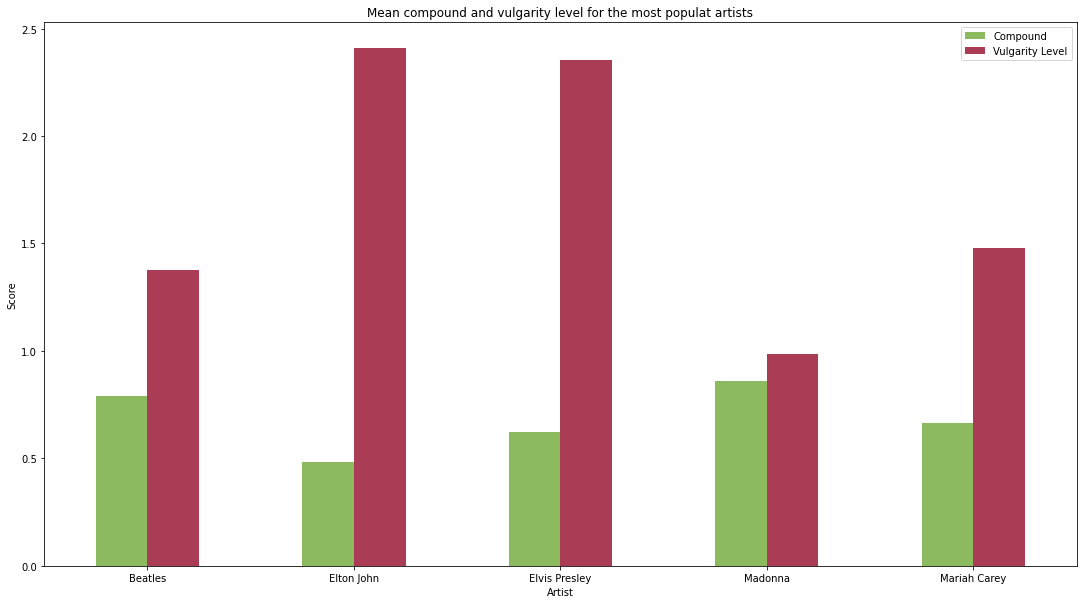

In [22]:
# Plot for mean compound and vulgarity level for the most popular artists
colors = ['#8cbB5f', '#ab3c55']
plot_art = grouped_by_artist.plot(kind = 'bar', color = colors, figsize = (18.5, 10), rot = 0, ylabel= 'Score', title = 'Mean compound and vulgarity level for the most populat artists')

### Statistics for songs which appeared on different end-year charts

In [23]:
count_most_popular_songs = songs[['Artist', 'Song Title']].value_counts().loc[lambda x: x > 1]
count_most_popular_songs_df = pd.DataFrame(count_most_popular_songs)
count_most_popular_songs_df = count_most_popular_songs_df.reset_index()

most_popular_songs_dup = songs.merge(count_most_popular_songs_df, on = ['Artist', 'Song Title'], how = 'inner', indicator = True)
most_popular_songs = most_popular_songs_dup.iloc[::2, :] # every second row
display(most_popular_songs)

,Position,Artist,Song Title,Year,JSON file,Split Names,Song Language,Lyrics,Tokenized Lyrics,Lemmatized Words,...,Tokenized Lyrics length,Tokenized Unique Lyrics length,Vulgarity Level,Negative,Neutral,Positive,Compound,Rate,0,_merge
0,15,Phil Harris,The Thing,1950,14.json,Phil Harris,en,while i was walking down the beach one bright ...,"[while, i, was, walking, down, the, beach, one...","[while, i, be, walk, down, the, beach, one, br...",...,409,147,21.62,0.040,0.838,0.122,0.9423,Positive,2,both
2,18,Patti Page,Tennessee Waltz,1950,17.json,Patti Page,en,i was dancing with my darling to the tennessee...,"[i, was, dancing, with, my, darling, to, the, ...","[i, be, dance, with, my, darling, to, the, ten...",...,140,43,0.00,0.147,0.325,0.529,0.9931,Positive,2,both
4,19,Tony Bennett,Rags To Riches,1953,108.json,Tony Bennett,en,i know i'd go from rages to riches if you woul...,"[i, know, i, d, go, from, rages, to, riches, i...","[i, know, i, d, go, from, rag, to, riches, if,...",...,112,74,0.00,0.026,0.543,0.430,0.9788,Positive,2,both
6,13,Tennessee Ernie Ford,Sixteen Tons,1955,162.json,Tennessee Ernie Ford,en,some people say a man is made out of mud a poo...,"[some, people, say, a, man, is, made, out, of,...","[some, people, say, a, man, be, make, out, of,...",...,295,115,0.67,0.138,0.790,0.072,-0.8860,Negative,2,both
8,15,Elvis Presley,Love Me Tender,1956,194.json,Elvis Presley,en,"love me tender, love me sweet never let me go ...","[love, me, tender, love, me, sweet, never, let...","[love, me, tender, love, me, sweet, never, let...",...,128,51,0.00,0.026,0.227,0.747,0.9984,Positive,2,both
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
472,39,Chris Brown & Young Thug,Go Crazy,2020,6618.json,Chris Brown,en,"oh, yeah (oh, is that kaniel again?) oh (ayy, ...","[oh, yeah, oh, is, that, kaniel, again, oh, ay...","[oh, yeah, oh, be, that, kaniel, again, oh, ay...",...,576,156,6.80,0.192,0.580,0.228,0.9360,Positive,2,both
474,41,Drake Featuring Lil Durk,Laugh Now Cry Later,2020,6620.json,Drake,en,"woah, woah yeah sometimes we laugh and somet...","[woah, woah, yeah, sometimes, we, laugh, and, ...","[woah, woah, yeah, sometimes, we, laugh, and, ...",...,629,208,3.32,0.266,0.555,0.179,-0.9827,Negative,2,both
476,47,24kGoldn Featuring iann dior,Mood,2020,6626.json,24kGoldn,en,"oh-oh-oh yeah, yeah, yeah, yeah (yeah) why y...","[oh, oh, oh, yeah, yeah, yeah, yeah, yeah, why...","[oh, oh, oh, yeah, yeah, yeah, yeah, yeah, why...",...,449,131,2.87,0.081,0.504,0.416,0.9982,Positive,2,both
478,49,Pop Smoke Featuring Lil Baby & DaBaby,For The Night,2020,6628.json,Pop Smoke,en,"cashmoneyap kill 'em, get 'em, get 'em, oh oh ...","[cashmoneyap, kill, em, get, em, get, em, oh, ...","[cashmoneyap, kill, em, get, em, get, em, oh, ...",...,637,215,7.65,0.251,0.595,0.155,-0.9928,Negative,2,both


### Topic identification

In [24]:
vectorize = TfidfVectorizer(stop_words = stop_words, max_features = 1000)
vectorized_text = vectorize.fit_transform(songs['Corpus'])
lda_model = LatentDirichletAllocation(n_components = 5, learning_method = 'online', random_state = 42, max_iter = 1)
lda_top = lda_model.fit_transform(vectorized_text)
vocab = vectorize.get_feature_names()

for i, comp in enumerate(lda_model.components_):
    vocab_comp = zip(vocab, comp)
    sorted_words = sorted(vocab_comp, key= lambda x:x[1], reverse = True)[:15]
    print("Topic " + str(i) + ": ")
    for t in sorted_words:
        print(t[0], end = " ")
    print("\n")

Topic 0: 
oh love know yeah baby ooh get go let say want like never feel make 

Topic 1: 
rockin ay nah boom boogie dem bass burnin higher rock wild freak tree ring get 

Topic 2: 
na da ayy angel ba ta di lo lift doo motion spin dat mr whoa 

Topic 3: 
get yeah like baby oh know go bitch fuck shit nigga uh girl make wanna 

Topic 4: 
la love dream heart know one life hold day never always night forever time go 

